In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# probability model
from scipy.stats import multivariate_normal

In [12]:
# Use the generated I3D-based boundaries (var-T, FNS ✗)
nalist = np.load(r"..\list\nalist_i3d.npy")
total_T = int(nalist[-1, 1])

# concat_UCF.npy was created via np.memmap (raw float32 file), so load with memmap
train_data = np.memmap(r"..\..\C2FPL\concat_UCF.npy", dtype="float32", mode="r", shape=(total_T, 10, 2048))

print("nalist shape:", nalist.shape, " total_T:", total_T)
print("train_data shape:", train_data.shape)

nalist shape: (1609, 2)  total_T: 779951
train_data shape: (779951, 10, 2048)


In [13]:
# Sanity check: video-0 span in the concatenated memmap
a0, b0 = map(int, nalist[0])
print("video0 span:", (a0, b0), "T0:", b0-a0)

x0 = train_data[a0:b0]
print("slice x0:", x0.shape)        # 여기서 (171,10,2048) 나와야 정상


video0 span: (0, 171) T0: 171
slice x0: (171, 10, 2048)


In [14]:
new_repr = []
for i, (fromid, toid) in enumerate(nalist):
    new_repr.append(train_data[fromid:toid])

len(new_repr)

1609

In [15]:
print("Total:", len(new_repr))
print("Assumed abnormal:", 811)
print("Assumed normal:", len(new_repr)-811)

# 경계 근처 샘플 확인
for i in range(805, 820):
    print(i, type(new_repr[i]))


Total: 1609
Assumed abnormal: 811
Assumed normal: 798
805 <class 'numpy.memmap'>
806 <class 'numpy.memmap'>
807 <class 'numpy.memmap'>
808 <class 'numpy.memmap'>
809 <class 'numpy.memmap'>
810 <class 'numpy.memmap'>
811 <class 'numpy.memmap'>
812 <class 'numpy.memmap'>
813 <class 'numpy.memmap'>
814 <class 'numpy.memmap'>
815 <class 'numpy.memmap'>
816 <class 'numpy.memmap'>
817 <class 'numpy.memmap'>
818 <class 'numpy.memmap'>
819 <class 'numpy.memmap'>


In [16]:
print("new_repr[0]:", new_repr[0].shape)

new_repr[0]: (171, 10, 2048)


In [17]:
new_repr[i].shape

(76, 10, 2048)

In [ ]:
def estimate_gauss(X):
    #m = X.shape[0]   # using only first dimension as we know it has only one feature - l2 norm
    
    #mu = np.mean(X, axis=0)
    #var = np.cov(X.T)
    X = np.asarray(X).reshape(-1)

    mu = float(np.mean(X))
    var = float(np.std(X, ddof=1))   # 논문식 sigma(표준편차). 변수명 var은 그대로 둠.

    return mu, var

def estimate_gauss_fpl(X):
    mu = np.mean(X, axis=0)
    var = np.cov(X.T)

    return mu, var

def covariance_mat(X):
    X = np.mean(X , axis= 1)
    X =  X.transpose(1,0)
    cov  = np.cov(X)

    return cov

def get_matrix(data): #입력 (T,10,2048)

    l2_norm = np.sqrt(np.sum(np.square(data), axis=2)) #2048차원에 대해 제곱합 -> 각 crop별 l2norm
    n_train_crop_l2_norm_mean = np.mean(l2_norm, axis= 1)  #crop축 평균 -> 스니펫별 대표 l2norm 값 벡터

    return n_train_crop_l2_norm_mean #(T,)


def diff_l2(new_repr):

    l2_norms = []
    for i in range(len(new_repr)):
        l2_norms.append(get_matrix(new_repr[i]))

    mean_v_l2 = []
    for i in range(len(l2_norms)):
        mean_v_l2.append(np.diff(l2_norms[i], n=1).max())
    return mean_v_l2


In [52]:
params = []
for i in range(len(new_repr)):

    param = get_matrix(new_repr[i])  
    mu, var = estimate_gauss(param)

    params.append((mu, var, )) #(N,2) -> 2차원 특징 벡터(mu, var)로 요약된 비디오 데이터

In [20]:
np.array(params).shape

(1609, 2)

### CPL (논문과 불일치)

In [11]:
#CPL (논문과 불일치)
from sklearn.mixture import GaussianMixture
import time

gmm = GaussianMixture(n_components=2, max_iter=150, random_state=0, covariance_type='spherical')
# gmm_scores = gmm.score_samples(params)
labels = gmm.fit_predict(params) 

y_gmm = gmm.fit_predict(params)
print(y_gmm.sum(), y_gmm.sum() / len(y_gmm))


score = y_gmm 
score = gmm.score_samples(params)   #log-likelihood
pct_threshold = np.percentile(score, 3) #하위 3%를 outlier로 간주해 res=1(이상) 처리
print(f'The threshold of the score is {pct_threshold:.2f}') 
res = np.array([1 if x < pct_threshold else 0 for x in score]) 
print(res.sum())

460 0.2858918582970789
The threshold of the score is -7.27
49


In [23]:
abnormal_portion = np.where(labels == 1)[0]
normal_portion = np.where(labels == 0)[0]
normal_portion.shape, abnormal_portion.shape

((1182,), (427,))

In [24]:
n_params = np.array(params)[normal_portion]
a_params = np.array(params)[abnormal_portion]
n_params.shape, a_params.shape

((1182, 2), (427, 2))

In [25]:
abag = list(zip(list(np.array(params)[abnormal_portion]), abnormal_portion))
nbag = list(zip(list(np.array(params)[normal_portion]), normal_portion))
len(abag), len(nbag)

(427, 1182)

In [26]:
print("len(nbag):", len(nbag))
print("type(nbag[0]):", type(nbag[0]))

# nbag[0]이 튜플/리스트면 feature가 [0]에 있음
try:
    x0 = nbag[0][0]
    print("type(nbag[0][0]):", type(x0))
    print("shape(nbag[0][0]):", np.array(x0).shape)
except Exception as e:
    print("nbag[0][0] 접근 실패:", e)
    print("shape(nbag[0]):", np.array(nbag[0]).shape)


len(nbag): 1182
type(nbag[0]): <class 'tuple'>
type(nbag[0][0]): <class 'numpy.ndarray'>
shape(nbag[0][0]): (2,)


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [28]:

nu = 1.0
step = 1
import time
start = time.time()
while len(abag) / len(nbag) < nu:
    
    temp_bag = nbag
    X = np.vstack([np.asarray(t[0], dtype=np.float32).reshape(-1) for t in temp_bag])  # (N, 2)
    y_gmm = gmm.fit_predict(X)
    score = gmm.score_samples(X)

    pct_threshold = np.percentile(score, 3) 
    res = np.array([1 if x < pct_threshold else 0 for x in score]) 
    print(f'The threshold of the score in step {step} is {pct_threshold:.2f}, abnormal part: {res.sum()}') 
    
    abnormal_portion = np.where(res == 1)[0]
    normal_portion = np.where(res == 0)[0]
    # abnormal_portion / normal_portion 은 index 배열 (np.where 결과)
    abag += [temp_bag[i] for i in abnormal_portion.tolist()]
    nbag  = [temp_bag[i] for i in normal_portion.tolist()]
    step += 1

print(time.time() - start)

The threshold of the score in step 1 is -19.88, abnormal part: 36
The threshold of the score in step 2 is -19.53, abnormal part: 35
The threshold of the score in step 3 is -19.18, abnormal part: 34
The threshold of the score in step 4 is -19.05, abnormal part: 33
The threshold of the score in step 5 is -18.95, abnormal part: 31
The threshold of the score in step 6 is -18.98, abnormal part: 31
The threshold of the score in step 7 is -18.87, abnormal part: 30
The threshold of the score in step 8 is -18.74, abnormal part: 29
The threshold of the score in step 9 is -18.47, abnormal part: 28
The threshold of the score in step 10 is -18.30, abnormal part: 27
The threshold of the score in step 11 is -18.24, abnormal part: 27
The threshold of the score in step 12 is -18.13, abnormal part: 26
The threshold of the score in step 13 is -17.96, abnormal part: 25
0.11525607109069824


In [29]:
print(np.where(np.array([x[1] for x in abag]) < 810)[0].shape, len([x[1] for x in abag]))
print('correctness acc: ', np.where(np.array([x[1] for x in abag]) < 810)[0].shape[0] / len([x[1] for x in abag]))

(442,) 819
correctness acc:  0.5396825396825397


In [30]:
print(np.where(np.array([x[1] for x in nbag]) > 810)[0].shape, len([x[1] for x in nbag]))
print('correctness acc: ', np.where(np.array([x[1] for x in nbag]) > 810)[0].shape[0] / len([x[1] for x in nbag]))

(422,) 790
correctness acc:  0.5341772151898734


In [31]:
temp = [k[1] for k in sorted([(x[1], 1.0) for x in abag] + [(x[1], 0.0) for x in nbag], key=lambda z: z[0])]
sum(temp), len(temp)

(819.0, 1609)

### CPL 논문대로 - at first regard entire set as normal, then iteratively divide them into two clusters / smaller cluster will be an abnormal / continue until eta > 1 

In [53]:
from sklearn.mixture import GaussianMixture
import numpy as np
import copy

# params: (N_videos, 2) = (mu, sigma) 리스트라고 가정
X = np.asarray(params, dtype=np.float32).reshape(-1, 2)

eta = 1.0
gmm = GaussianMixture(
    n_components=2,
    max_iter=150,
    random_state=0,
    covariance_type="spherical"
)

# t=0, C0=전체, C1=empty
C0 = np.arange(len(X), dtype=int)
C1 = np.array([], dtype=int)
t = 0

# ✅ step별로 "어떻게 갈라졌는지" 저장할 히스토리
cpl_hist = []

while (len(C1) / max(len(C0), 1)) <= eta and len(C0) >= 2:
    gmm.fit(X[C0])
    lab = gmm.predict(X[C0])  # C0 내부 군집 번호(0/1)

    idx0 = C0[lab == 0]
    idx1 = C0[lab == 1]

    # 작은 클러스터(Cs)를 anomaly로 이동 후보
    if len(idx0) < len(idx1):
        Cs, Cl = idx0, idx1
    else:
        Cs, Cl = idx1, idx0

    cur_ratio  = len(C1) / max(len(C0), 1)
    next_ratio = (len(C1) + len(Cs)) / max((len(C0) - len(Cs)), 1)

    # ✅ 이번 step 스냅샷 저장 (C0를 어떻게 두 덩어리로 갈랐는지)
    cpl_hist.append({
        "t": t,
        "C0_before": C0.copy(),
        "C1_before": C1.copy(),
        "Cs": Cs.copy(),
        "Cl": Cl.copy(),
        "cur_ratio": float(cur_ratio),
        "next_ratio": float(next_ratio),
        # decision boundary까지 그리고 싶으면 fitted gmm 보관(복사)
        "gmm": copy.deepcopy(gmm),
    })

    if next_ratio > eta:
        break

    C1 = np.concatenate([C1, Cs])
    C0 = Cl
    t += 1

# 최종 pseudo video label: C0이면 0, C1이면 1
temp = np.zeros(len(X), dtype=np.float32)
temp[C1] = 1.0

print("CPL done. normal:", len(C0), "anom:", len(C1), "ratio:", len(C1)/max(len(C0),1), "steps:", len(cpl_hist))


CPL done. normal: 1163 anom: 446 ratio: 0.3834909716251075 steps: 2


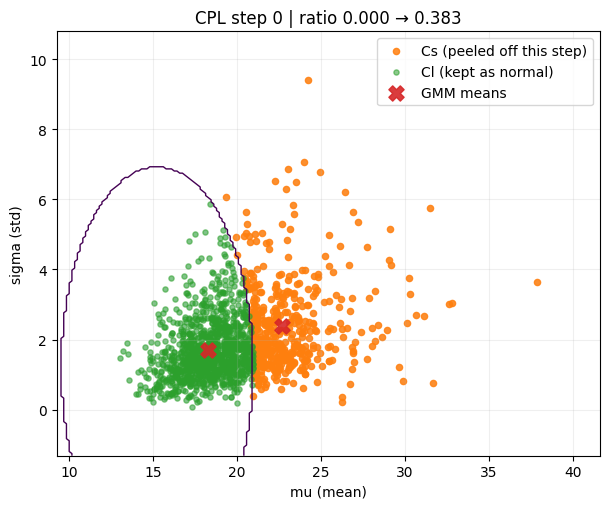

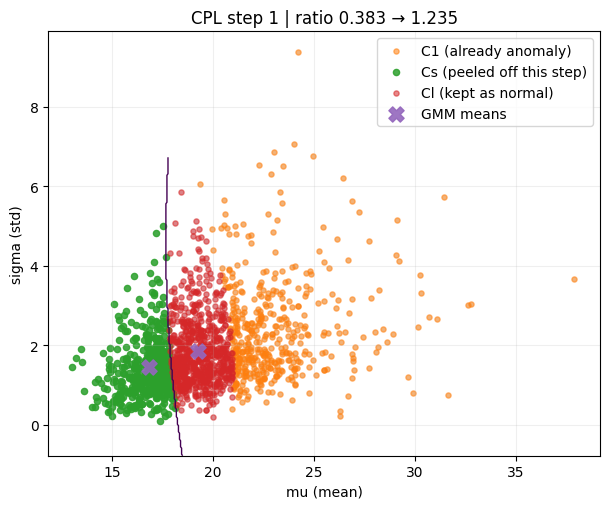

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cpl_step(X, step, show_boundary=True, grid_res=200):
    X = np.asarray(X, dtype=np.float32).reshape(-1, 2)

    C1b = step["C1_before"]
    Cs  = step["Cs"]
    Cl  = step["Cl"]
    gmm = step["gmm"]

    plt.figure(figsize=(6.2, 5.2))

    # 전체(연하게)
    plt.scatter(X[:,0], X[:,1], s=6, alpha=0.08)

    # 이전까지 누적 anomaly
    if len(C1b) > 0:
        plt.scatter(X[C1b,0], X[C1b,1], s=14, alpha=0.55, label="C1 (already anomaly)")

    # 이번 step에서 떨어져 나가는 작은 군집(Cs)
    plt.scatter(X[Cs,0], X[Cs,1], s=20, alpha=0.85, label="Cs (peeled off this step)")

    # 이번 step에서 남는 큰 군집(Cl)
    plt.scatter(X[Cl,0], X[Cl,1], s=14, alpha=0.55, label="Cl (kept as normal)")

    # GMM 평균점 표시
    means = gmm.means_
    plt.scatter(means[:,0], means[:,1], s=120, marker="X", alpha=0.9, label="GMM means")

    # (선택) decision boundary
    if show_boundary:
        # 현재 step에서 학습에 사용된 영역 기준으로 grid 생성
        xmin, xmax = X[step["C0_before"],0].min(), X[step["C0_before"],0].max()
        ymin, ymax = X[step["C0_before"],1].min(), X[step["C0_before"],1].max()
        pad_x = 0.15 * (xmax - xmin + 1e-6)
        pad_y = 0.15 * (ymax - ymin + 1e-6)

        xs = np.linspace(xmin - pad_x, xmax + pad_x, grid_res)
        ys = np.linspace(ymin - pad_y, ymax + pad_y, grid_res)
        XX, YY = np.meshgrid(xs, ys)
        grid = np.c_[XX.ravel(), YY.ravel()]
        zz = gmm.predict(grid).reshape(grid_res, grid_res)

        plt.contour(XX, YY, zz, levels=[0.5], linewidths=1)

    plt.title(f"CPL step {step['t']} | ratio {step['cur_ratio']:.3f} → {step['next_ratio']:.3f}")
    plt.xlabel("mu (mean)")
    plt.ylabel("sigma (std)")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


# ✅ 예시: step 0~마지막까지 쭉 보기 (너무 많으면 range 조절)
for k in range(len(cpl_hist)):
    plot_cpl_step(X, cpl_hist[k], show_boundary=True)


In [23]:
from sklearn.mixture import GaussianMixture
import numpy as np

# params: (N_videos, 2) 가정. (mu, sigma) 튜플 리스트면 아래처럼 안전하게 변환하기 위함.
X = np.asarray(params, dtype=np.float32)
X = X.reshape(len(X), 2)

eta = 1.0
gmm = GaussianMixture(
    n_components=2,
    max_iter=150,
    random_state=0,
    covariance_type="spherical"
)

# 논문: t=0, C0 = 전체, C1 = empty 
C0 = np.arange(len(X))           # normal cluster indices
C1 = np.array([], dtype=int)     # anomaly cluster indices
t = 0

# 논문: while |C1|/|C0| ≤ eta do ... 
while (len(C1) / max(len(C0), 1)) <= eta and len(C0) >= 2:
    # 현재 normal cluster(C0)만 다시 2개로 클러스터링 
    gmm.fit(X[C0])
    print("converged:", gmm.converged_, "n_iter:", gmm.n_iter_)
    lab = gmm.predict(X[C0])  # 0/1은 그냥 C0 안에서의 군집 번호

    idx0 = C0[lab == 0]
    idx1 = C0[lab == 1]

    # 논문: 작은 클러스터 Cs를 anomaly에 누적, 큰 클러스터 Cl을 normal로 유지 
    if len(idx0) < len(idx1):
        Cs, Cl = idx0, idx1
    else:
        Cs, Cl = idx1, idx0

    cur_ratio = len(C1) / max(len(C0),1)
    next_ratio = (len(C1) + len(Cs)) / max((len(C0)-len(Cs)),1)

    if next_ratio > eta:
        break
    
    C1 = np.concatenate([C1, Cs])
    C0 = Cl
    t += 1

# 논문: 최종 pseudo video label: C0이면 0, 아니면 1
temp = np.zeros(len(X), dtype=np.float32)
temp[C1] = 1.0

print("CPL done. normal:", len(C0), "anom:", len(C1), "ratio:", len(C1)/max(len(C0),1))


converged: True n_iter: 4
converged: True n_iter: 4
CPL done. normal: 1163 anom: 446 ratio: 0.3834909716251075


In [55]:
pred_ab = set(np.where(temp == 1)[0])
pred_no = set(np.where(temp == 0)[0])

gt_ab = set(range(0, 811))          # 0-810 이상
gt_no = set(range(811, 1610))    # 811-1609 정상

tp = len(pred_ab & gt_ab)
fp = len(pred_ab & gt_no)
fn = len(pred_no & gt_ab)
tn = len(pred_no & gt_no)

print("TP FP FN TN:", tp, fp, fn, tn)
print("precision:", tp / max(tp+fp,1))
print("recall:", tp / max(tp+fn,1))


TP FP FN TN: 262 184 549 614
precision: 0.5874439461883408
recall: 0.32305795314426633


X shape: (1609, 2)  y: (1609,) anom ratio: 0.2771908017402113


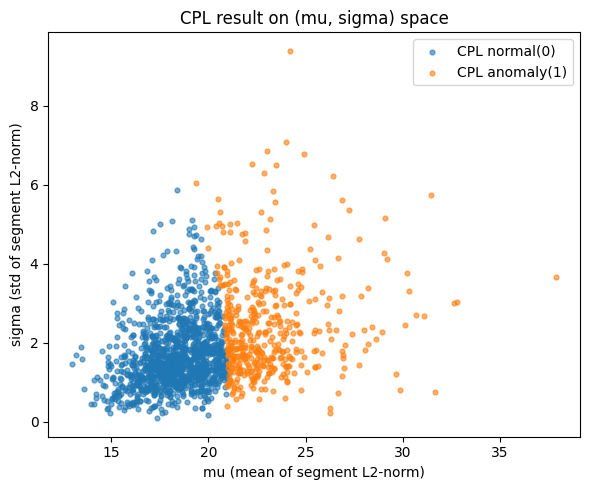

In [56]:
#cpl 결과 시각화
#(mu, sigma) 산점도
import numpy as np
import matplotlib.pyplot as plt

# params: list of (mu, sigma) or (mu, var) 튜플들
X = np.asarray(params, dtype=np.float32).reshape(-1, 2)

# temp: CPL 최종 pseudo video label (0/1), 길이 = len(X)
y = temp.astype(int)

print("X shape:", X.shape, " y:", y.shape, "anom ratio:", y.mean())

plt.figure(figsize=(6,5))
plt.scatter(X[y==0, 0], X[y==0, 1], s=12, alpha=0.6, label="CPL normal(0)")
plt.scatter(X[y==1, 0], X[y==1, 1], s=12, alpha=0.6, label="CPL anomaly(1)")
plt.xlabel("mu (mean of segment L2-norm)")
plt.ylabel("sigma (std of segment L2-norm)")   # var 변수지만 std를 쓰고 있음
plt.title("CPL result on (mu, sigma) space")
plt.legend()
plt.tight_layout()
plt.show()


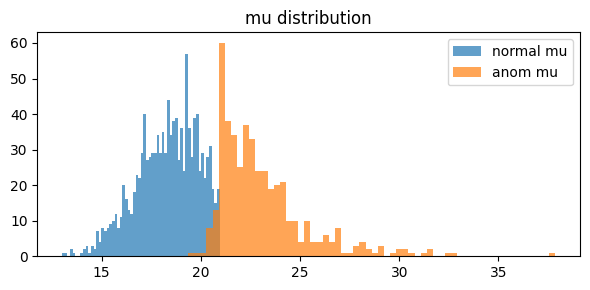

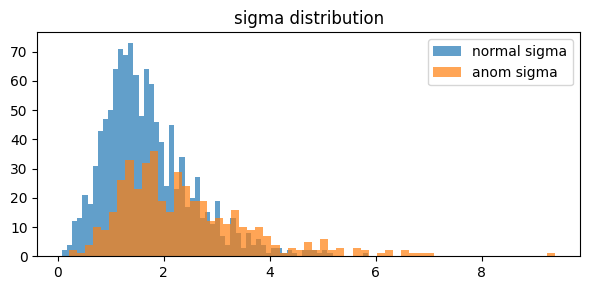

In [57]:
plt.figure(figsize=(6,3))
plt.hist(X[y==0,0], bins=60, alpha=0.7, label="normal mu")
plt.hist(X[y==1,0], bins=60, alpha=0.7, label="anom mu")
plt.title("mu distribution"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.hist(X[y==0,1], bins=60, alpha=0.7, label="normal sigma")
plt.hist(X[y==1,1], bins=60, alpha=0.7, label="anom sigma")
plt.title("sigma distribution"); plt.legend(); plt.tight_layout(); plt.show()


### fpl

In [26]:
# normal set creation
normal_set = {}

for i in range(len(new_repr)):
    if temp[i] == 0.0:
        normal_set[i] = new_repr[i]

In [27]:
# abnormal set creation
abnormal_set = {}
for i in range(len(new_repr)):
    if temp[i] == 1.0:
        abnormal_set[i] = new_repr[i]

In [28]:
l2_norms_N = np.empty(0,)
for (idel, sample) in normal_set.items(): 
    
    # print(sample.shape)
    
    #normal 비디오들에서 모든 segment들의 l2 값을 한 벡터로 모음.
    l2_norms_N = np.append(l2_norms_N,get_matrix(sample))

In [29]:
len(normal_set), len(abnormal_set)

(1163, 446)

In [30]:
mu_GMM, var_GMM = estimate_gauss_fpl(np.array(l2_norms_N))

In [31]:
# probability model
from scipy.stats import multivariate_normal
p = multivariate_normal(mu_GMM, var_GMM)

In [32]:
import numpy as np

def compute_probs_and_conf_final(sample, p, eps=1e-12):
    sample_matrix = get_matrix(sample)
    probs = p.pdf(sample_matrix)
    probs = np.asarray(probs, dtype=np.float64)

    m = len(probs)
    if m == 0:
        return probs.astype(np.float64), np.zeros((0,), dtype=np.float32)

    # anomaly evidence: -log(p)
    conf = -np.log(probs + eps)

    # normalize to [0,1] (video-wise)
    conf = (conf - conf.min()) / (conf.max() - conf.min() + eps)

    # change magnitude
    delta = np.abs(np.diff(conf, prepend=conf[0]))

    # combine + renorm
    conf_final = conf * delta
    conf_final = (conf_final - conf_final.min()) / (conf_final.max() - conf_final.min() + eps)
    conf_final = np.clip(conf_final, 0.0, 1.0).astype(np.float32)
    conf_final = conf.astype(np.float32)

    return probs, conf_final


In [33]:
import math
import numpy as np

ground_truth = {}
beta = 0.2

for (idel, sample) in abnormal_set.items():
    probs, conf_final = compute_probs_and_conf_final(sample, p)
    m = len(probs)

    if m == 0:
        ground_truth[idel] = {
            "conf": conf_final,
            "hard": np.zeros((0,), dtype=np.int8),
            "win": np.zeros((0,), dtype=np.uint8),
        }
        continue

    window_size = int(math.ceil(beta * m))
    window_size = max(1, min(window_size, m))

    # probs 기준 window mean 계산
    csum = np.cumsum(np.concatenate(([0.0], probs)))
    win_sums = csum[window_size:] - csum[:-window_size]
    win_means = win_sums / window_size

    start = int(np.argmin(win_means))  # ✅ 평균 p-value 최소 구간 = 이상 후보 (원래 방식)

    win_mask = np.zeros(m, dtype=np.uint8)
    win_mask[start:start + window_size] = 1

    hard = np.zeros(m, dtype=np.int8)
    hard[start:start + window_size] = 1

    ground_truth[idel] = {
        "conf": conf_final.astype(np.float32),  # 전체 구간 conf score 저장
        "hard": hard,
        "win": win_mask,
    }


In [34]:
for (idel, sample) in normal_set.items():
    probs, conf_final = compute_probs_and_conf_final(sample, p)
    m = len(conf_final)

    hard = np.zeros(m, dtype=np.int8)          # ✅ 정상은 전구간 0
    win_mask = np.zeros(m, dtype=np.uint8)     # 디버그용(없어도 됨)

    ground_truth[idel] = {
        "conf": conf_final,
        "hard": hard,
        "win": win_mask,
    }

In [35]:
final_conf = []
final_hard = []

for i in range(len(new_repr)):
    Ti = new_repr[i].shape[0]

    conf_i = ground_truth[i]["conf"]
    hard_i = ground_truth[i]["hard"]

    assert len(conf_i) == Ti, (i, len(conf_i), Ti)
    assert len(hard_i) == Ti, (i, len(hard_i), Ti)

    final_conf += conf_i.tolist()
    final_hard += hard_i.tolist()

final_conf = np.array(final_conf, dtype=np.float32)
final_hard = np.array(final_hard, dtype=np.int8)

np.save(r"..\Unsup_labels\UCF_conf_score.npy", final_conf)
np.save(r"..\Unsup_labels\UCF_hard_label.npy", final_hard)


In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fpl_debug(sample, p, gt_entry, beta=0.2, alpha=0.05, title=""):
    """
    sample: (T,10,2048) 같은 비디오 feature
    p: 정상 분포 pdf 객체 (p.pdf 가능)
    gt_entry: ground_truth[idel] = {"conf","hard","win"}
    """

    # probs 다시 계산 (현재 코드에서 probs를 저장 안 하니까)
    sample_matrix = get_matrix(sample)
    probs = np.asarray(p.pdf(sample_matrix), dtype=np.float64)

    conf = np.asarray(gt_entry["conf"], dtype=np.float32)
    hard = np.asarray(gt_entry["hard"], dtype=np.int8)
    win  = np.asarray(gt_entry["win"],  dtype=np.uint8)

    T = len(probs)
    x = np.arange(T)

    fig, ax = plt.subplots(3, 1, figsize=(12,6), sharex=True)

    # (1) p-value 곡선 + threshold + 선택 윈도우 음영
    ax[0].plot(x, probs, linewidth=1)
    ax[0].axhline(alpha, linestyle="--", linewidth=1)
    ax[0].fill_between(x, probs.min(), probs.max(), where=(win==1), alpha=0.2, label="selected window")
    ax[0].set_ylabel("p-value (pdf)")
    ax[0].set_title(title)
    ax[0].legend()

    # (2) conf_final
    ax[1].plot(x, conf, linewidth=1)
    ax[1].fill_between(x, 0, 1, where=(win==1), alpha=0.15)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].set_ylabel("conf_final")

    # (3) hard 라벨(1 / 0 / -1)을 보기 좋게
    # -1은 0으로 눌러서 “학습 제외”로 해석 가능하게 표시
    hard_plot = hard.copy().astype(np.float32)
    hard_plot[hard_plot < 0] = 0.0
    ax[2].step(x, hard_plot, where="post", linewidth=2, label="hard==1")
    ax[2].set_ylim(-0.1, 1.1)
    ax[2].set_ylabel("hard label")
    ax[2].set_xlabel("segment index")
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    # 구간 출력
    if win.sum() > 0:
        s = int(np.where(win==1)[0][0])
        e = int(np.where(win==1)[0][-1])
        print(f"selected window: [{s}, {e}]  (len={e-s+1}, T={T}, beta~{beta})")
    print("hard counts:", {v:int((hard==v).sum()) for v in [-1,0,1]})


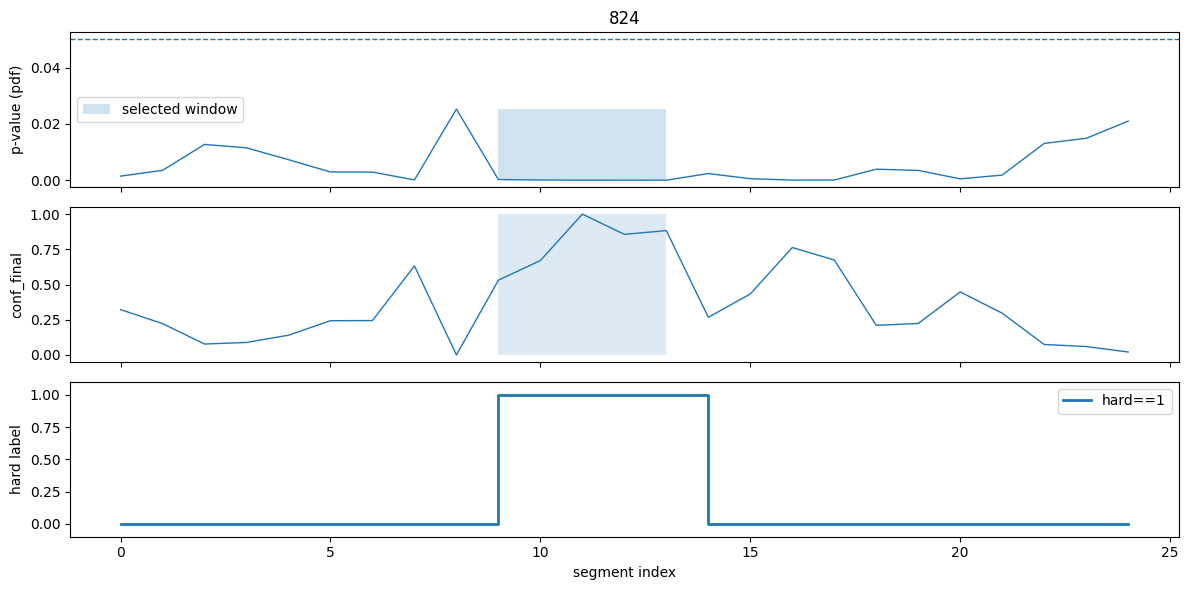

selected window: [9, 13]  (len=5, T=25, beta~0.2)
hard counts: {-1: 0, 0: 20, 1: 5}


In [183]:
idel = list(abnormal_set.keys())[264]   # 혹은 특정 id
sample = abnormal_set[idel]
plot_fpl_debug(sample, p, ground_truth[idel], beta=beta, alpha=0.05, title=str(idel))


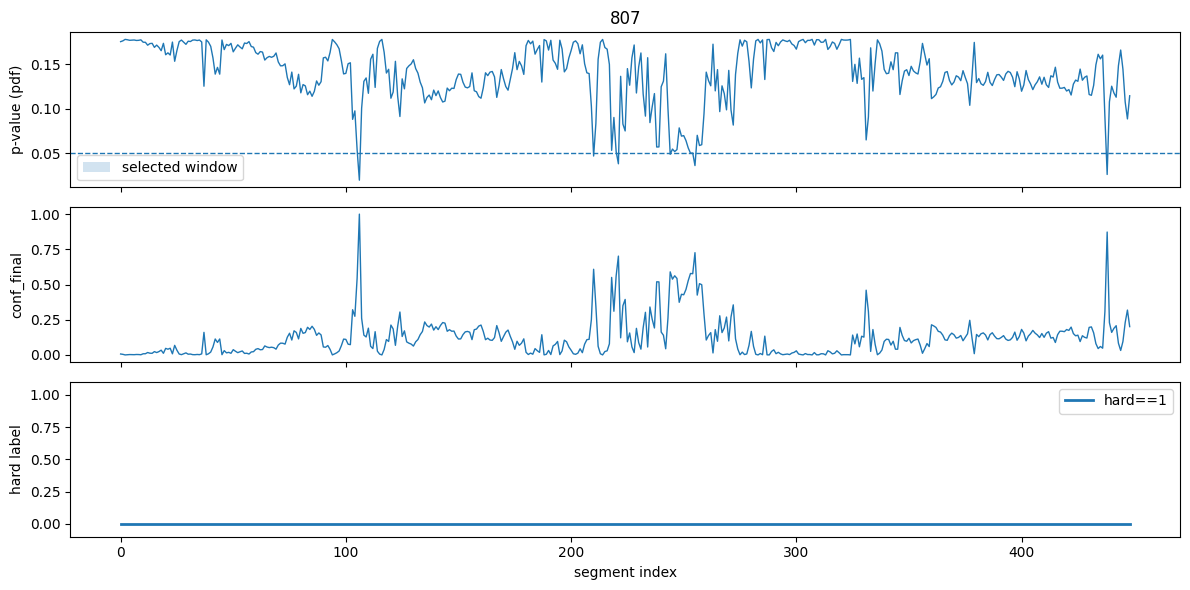

hard counts: {-1: 0, 0: 449, 1: 0}


In [168]:
idel = list(normal_set.keys())[546]
sample = normal_set[idel]
plot_fpl_debug(sample, p, ground_truth[idel], beta=beta, alpha=0.05, title=str(idel))


In [ ]:
''' 요게 원래 버전
ground_truth = {} 
length = 0.2 
for (idel, sample) in abnormal_set.items(): 

    # feature extraction 
    # sample_matrix = np.sum(np.square(sample), axis=1)  # for just l2
    sample_matrix = get_matrix(sample)
    
    # get p values
    probs = p.pdf(sample_matrix)
    probs.shape
    temp_list = []
    temp_list += [0.0] * len(probs)
    
    window_size = int(len(probs) * length)  # fixed
    temp = []
    for idx in range(0, len(probs) - window_size + 1):
        arr = 0
        for i in range(idx, idx + window_size - 1):
            arr += abs(probs[i+1] - probs[i])
        temp.append(arr)
    #p value 변화량이 가장 큰 구간을 이상 구간으로
    for i in range(temp.index(max(temp)), temp.index(max(temp)) + window_size):
        temp_list[i] = 1.0

    ground_truth[idel] = temp_list
'''
import math

ground_truth = {}
beta = 0.2

for (idel, sample) in abnormal_set.items():
    sample_matrix = get_matrix(sample)
    '''확인용
    arr = np.asarray(sample_matrix)
    print("idel:", idel)
    print("sample type/shape:", type(sample), getattr(sample, "shape", None))
    print("sample_matrix type:", type(sample_matrix))
    print("sample_matrix np.shape:", arr.shape, "ndim:", arr.ndim, "dtype:", arr.dtype)
    '''
    probs = p.pdf(sample_matrix) 
    probs = np.asarray(probs, dtype=np.float64)
    #print("probs shape:", probs.shape, "ndim:", probs.ndim)
    
    m = len(probs)
    if m==0:
        ground_truth[idel] = []
        continue
    
    window_size = int(math.ceil(beta*m))
    window_size = max(1, min(window_size, m))

    csum = np.cumsum(np.concatenate(([0.0], probs))) 
    win_sums = csum[window_size:] - csum[:-window_size]
    win_means = win_sums / window_size

    start = int(np.argmin(win_means)) #윈도우 선택

    #추가 (후보 anomaly region)
    win_mask = np.zeros(m, dtype=np.float32)
    win_mask[start:start+window_size] = 1.0 

    #anomaly evidence 만들기: -log + 정규화
    conf = -np.log(probs + 1e-12) 
    conf = (conf - conf.min()) / (conf.max() - conf.min() + 1e-12)
    
    #변화량 기준 추가
    delta = np.abs(np.diff(conf, prepend=conf[0]))

    #결합 conf_final = self-paced에 쓸 conf_score
    conf_final = conf * delta
    conf_final = (conf_final - conf_final.min()) / (conf_final.max() - conf_final.min() + 1e-12) #추가
    conf_final = np.clip(conf_final, 0.0, 1.0)

    # 초기 hard label 선정 
    #t_pos = 0.6 #확실한 이상만
    #t_neg = 0.1 #확실한 정상만
    #hard[(conf_final >= t_pos)] = 1
    #hard[(conf_final <= t_neg)] = 0
    # win_mask 안에서만 abnormal 확정 (밖에 있던 애들은 ignore로 모른다고 남기기)
    #hard[(win_mask == 0) & (hard == 1)] = -1

    hard = -np.ones(m, dtype=np.int8)  # -1 = ignore

    hard[start:start+window_size] = 1

    ground_truth[idel] = {
        "conf": conf_final.astype(np.float32),  #(m,) 전 구간 confidence score
        "hard": hard.astype(np.int8),   #(m,) -1/0/1
        "win": win_mask.astype(np.uint8), #(m,) 후보 window (디버그용)
    }

    """ Dirichlet 수식
    e_anom = conf_final

    e_norm = np.ones_like(conf_final)

    alpha_anom = e_anom + 1.0
    alpha_norm = e_norm + 1.0

    S = alpha_anom + alpha_norm

    p_anom = alpha_anom / S
    uncertainty = 2.0 / S
    confidence = 1.0 - uncertainty

    soft_label = p_anom * confidence
    
    #temp_list = np.zeros(m,dtype=np.float32)
    #temp_list[start:start+window_size] = soft_label[start:start+window_size]  #soft label로 변경
    #ground_truth[idel] = temp_list.tolist()
    """


In [57]:
len(probs)

151

In [ ]:
#confidence score 저장용 

final_conf = []
abnormal_conf = []
for i in range(len(new_repr)):
    Ti = new_repr[i].shape[0]
    if i in normal_set.keys():
        final_conf += [0.0] * Ti
    else:
        final_conf += ground_truth[i]["conf"].tolist()
        abnormal_conf+= ground_truth[i]["conf"].tolist()

In [59]:
len(final_conf)

779951

In [60]:
final_conf = np.array(final_conf, dtype=np.float32)
np.save(r"..\Unsup_labels\UCF_conf_score.npy", final_conf)

#print("final_gt shape:", final_gt.shape, "sum:", final_gt.sum())
#np.save(r"..\Unsup_labels\UCF_unsup_labels_i3d_varT_softd.npy", final_gt)

In [61]:
#hard init 저장용 

final_hard = []
abnormal_hard = []
for i in range(len(new_repr)):
    Ti = new_repr[i].shape[0]
    if i in normal_set.keys(): #normal 비디오는 모두 0
        final_hard += [0] * Ti
    else:
        final_hard += ground_truth[i]["hard"].tolist()
        abnormal_hard += ground_truth[i]["hard"].tolist()

In [62]:
final_hard = np.array(final_hard, dtype=np.int8)
np.save(r"..\Unsup_labels\UCF_hard_init.npy", final_hard)

In [54]:
final_win = []
abnormal_win = []

for i in range(len(new_repr)):
    Ti = new_repr[i].shape[0]
    if i in normal_set.keys():
        final_win += [0] * Ti
    else:
        final_win += ground_truth[i]["win"].tolist()
        abnormal_win += ground_truth[i]["win"].tolist()

final_win = np.array(final_win, dtype=np.uint8)
np.save(r"..\Unsup_labels\UCF_win_mask.npy", final_win)

In [55]:
pseudo = np.load("../Unsup_labels/UCF_unsup_labels_i3d_varT_softd.npy")
print(pseudo.shape, pseudo.dtype)
print("mean:", pseudo.mean(), "sum:", pseudo.sum()) #sum 결과 = 전체 스니펫(779951개) 중 약 5.7만 개를 이상(1)으로 찍었음을 알 수 있음. 
print("ones ratio:", pseudo.mean())


FileNotFoundError: [Errno 2] No such file or directory: '../Unsup_labels/UCF_unsup_labels_i3d_varT_softd.npy'